# <center>CS 4331 - Data Mining</center>
## <center>Spring 2020</center>
### <center>Project 1</center>
#### <center>Joshua Ball | Dipendra Yadav</center>

In [1]:
# Importing the libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
# Reading the data and displaying the first 5 rows
dataset = pd.read_csv("hotel_bookings.csv")
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Problem Understanding Phase


### Problem Objective
    Traveling is expensive overall, but one of the biggest costs associated with a trip is often the lodging.
    Studies have suggested that the best time to buy a plane ticket for lower-price options is 70 days in advance.
    But does the same reasoning apply to hotel rooms?

### Can this problem be solved using Data Science?
    We are using data from https://www.kaggle.com/ekretsch/hotel-booking-dataset to develop a clustering algorithm 
    that can find out the best time of the year to book a hotel room in order to get best prices in the market.

## Data Preparation Phase
    Preparing the data for analysis


In [3]:
# Checking for null values and datatypes of each attributes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
""" Here we can see that data has int, float and object values. First of all we have to represent the object
    values to some numerical values so that we can perform exploratory data analysis. Also, we have to fix
    the NaN values present in the dataset."""

' Here we can see that data has int, float and object values. First of all we have to represent the object\n    values to some numerical values so that we can perform exploratory data analysis. Also, we have to fix\n    the NaN values present in the dataset.'

In [5]:
# Cleaning the dataset (looking for outliers and NaN values)
data_size = dataset.shape
print('The size of the dataset is {}'.format(data_size))


# Checking for NaNs in the dataset
print('The attributes with NaNs are as follows:')
NaNs = pd.DataFrame(dataset.isnull().sum())
NaNs

The size of the dataset is (119390, 32)
The attributes with NaNs are as follows:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


    Here we can see there are so many instances in attributes in country, agent, and company that carries NaNs. For this project, country, agent, and company columns do not add up to the value or contribute to the fluctuation in the pricing over the year. Therefore, we are going to drop these two columns. However, We would have needed to do some interpolation to fill in these values in the data preparation phase of data mining in case these attributes were important in the formation of clusters for this project.

In [6]:
dataset = dataset.drop(columns = ['country','agent', 'company','children'])

# Validation of the dataset 
print('The cleaned dataset without NaNs are as follows:')
new_data = pd.DataFrame(dataset.isnull().sum())
new_data

The cleaned dataset without NaNs are as follows:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [7]:
# Now lets check how the data is distributed statistically
dataset.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [8]:
# Checking the number of instances in each month to have a general idea of when people travel most
dataset.arrival_date_month.value_counts()

August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

From above data we can see that the months of August followed by July, May, and October has the most travellers.

To use linear regression for modelling,its necessary to remove correlated variables to improve your model.One can find correlations using pandas “.corr()” function and can visualize the correlation matrix using a heatmap in seaborn.

Text(0.5, 1, 'Correlation Heatmap before correction')

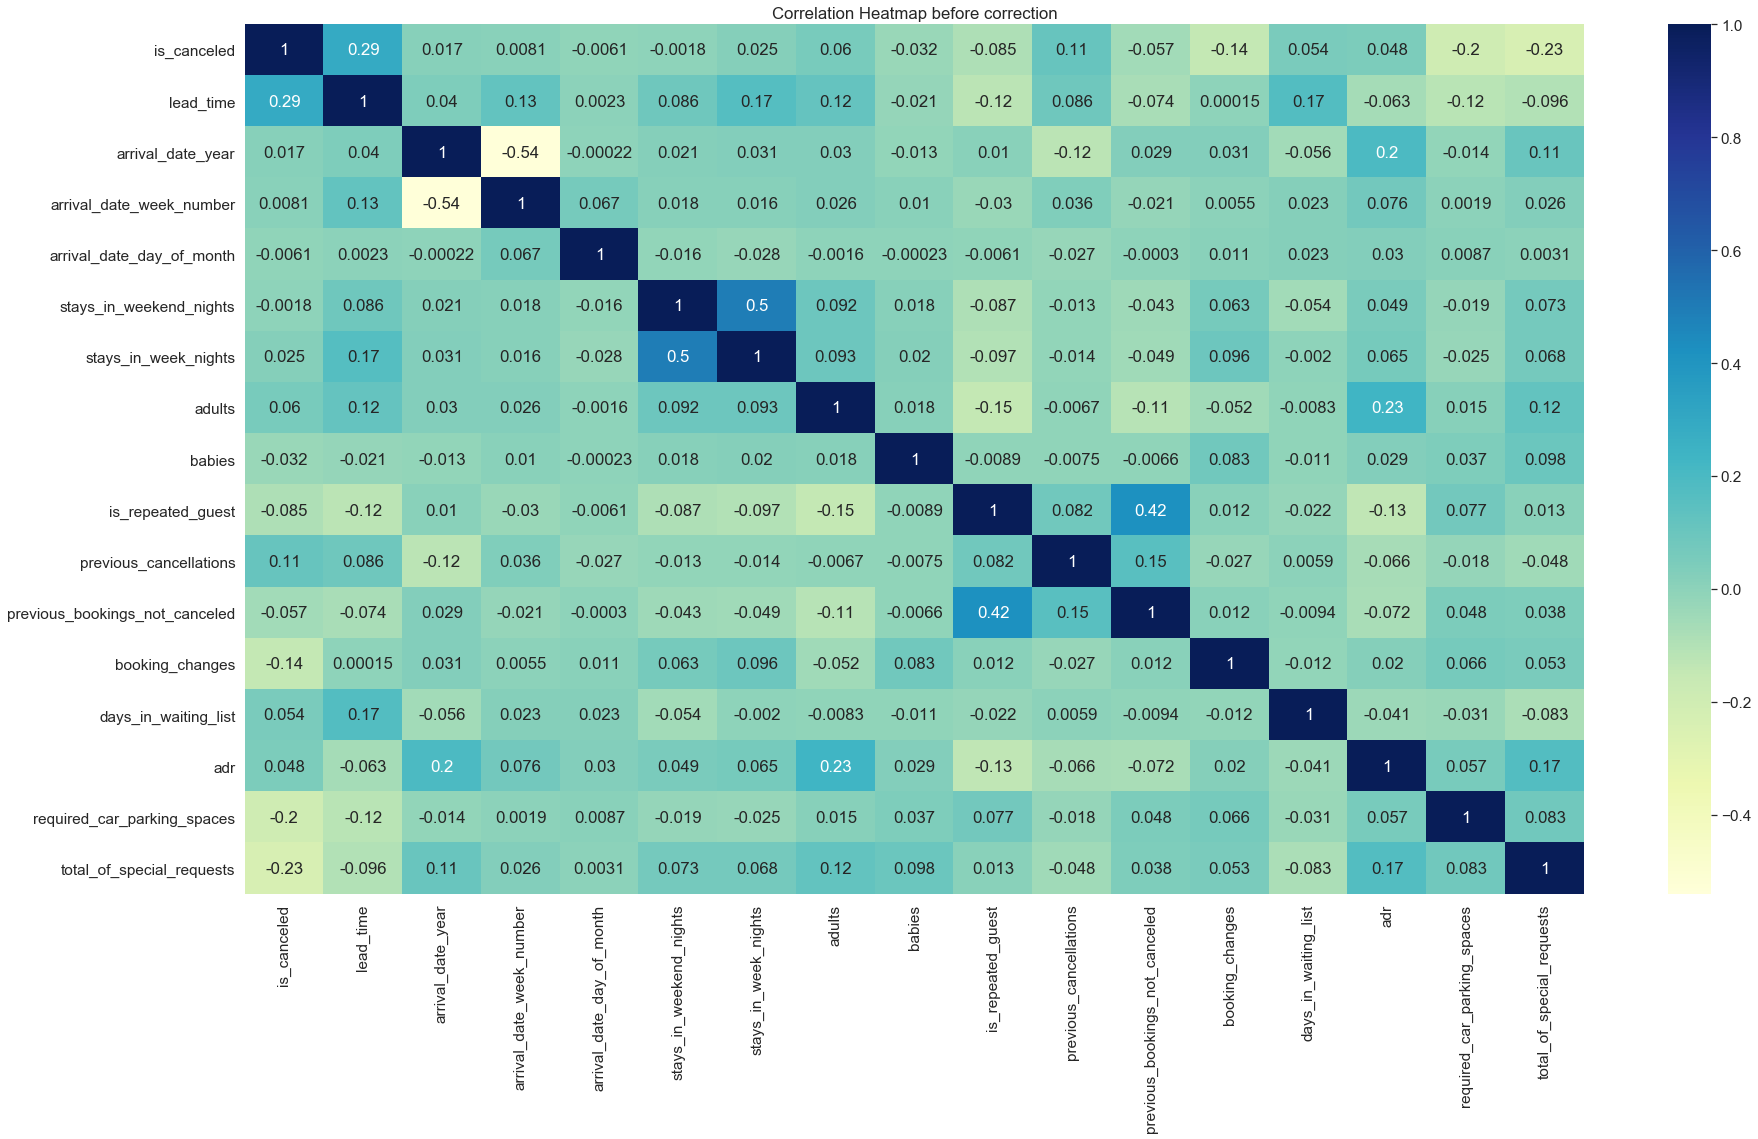

In [9]:
# Representing the data using heatmap before correction
data_corr = dataset.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(30, 16))
sns.heatmap(data_corr,annot = True,cmap = "YlGnBu")
plt.title('Correlation Heatmap before correction')


In [10]:
#Calculating average rate paid per total stay by multiplying average daily rate * total time stayed
dataset['rate_per_stay'] = dataset['adr'] * (dataset['stays_in_weekend_nights'] + dataset['stays_in_week_nights'])

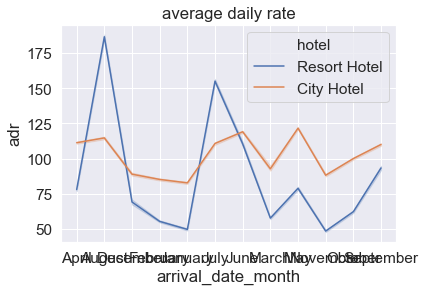

Text(0.5, 1.0, 'rate_per_stay')

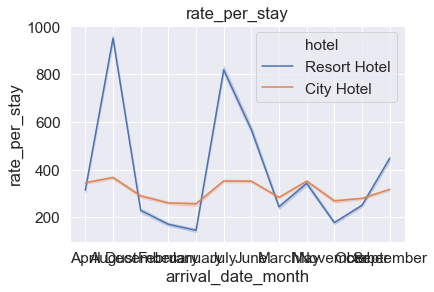

In [11]:
sns.lineplot(data = dataset, x = 'arrival_date_month', y = 'adr', hue = 'hotel').set_title("average daily rate")
plt.show()
sns.lineplot(data = dataset, x = 'arrival_date_month', y = 'rate_per_stay', hue = 'hotel').set_title("rate_per_stay")    

In [12]:
#Graphs show a clear trend where certian months have a higher overall price paid and adr

In [13]:
#Changing months from str -> int so it is no longer categorical and can be used in clustering model
#Code isn't working inside Jupyter but works in a regular enviorment so we will just read in a new corrected file.

#month_map = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,
             #'September':9,'October':10,'November':11,'December':12}
#dataset['arrival_date_month'] = dataset['arrival_date_month'].map(month_map)
dataset = pd.read_csv("hotel_bookings_month_corrected.csv")

Text(0.5, 1, 'Correlation Heatmap after correction')

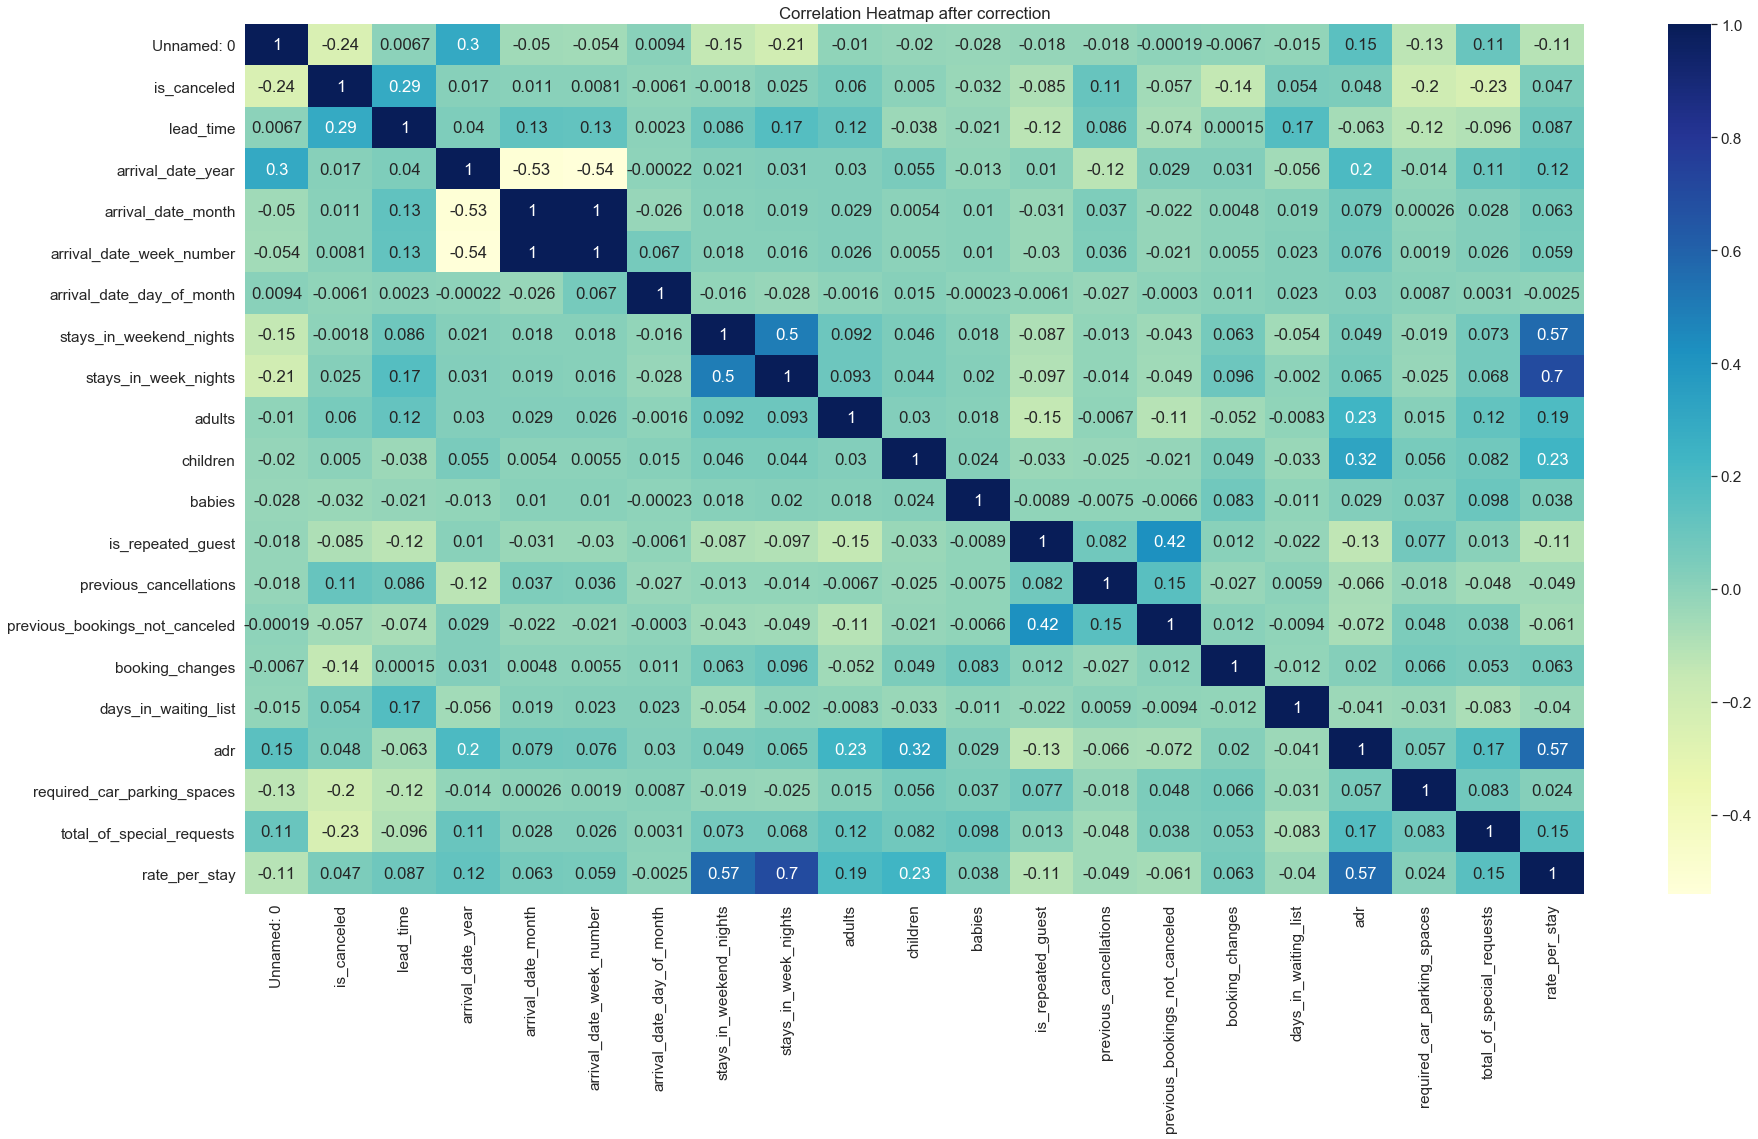

In [14]:
# Representing the data using heatmap after correction
data_corr = dataset.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(30, 16))
sns.heatmap(data_corr,annot = True,cmap = "YlGnBu")
plt.title('Correlation Heatmap after correction')


        ==> Dark shades represents positive correlation while lighter shades represents negative correlation.
    Here we can infer that “arrival_date_month” has strong positive correlation with “arrival_date_week_number” whereas it has strong negative correlation with “arrival_date_year”. Furthermore,
    if correlation is zero we can infer there is no linear relationship between these two predictors and it is safe to drop these features in case we will be applying Linear Regression model to the dataset.

In [15]:
#Next we are removing cases where the customer canceled their reservations
dataset.loc[dataset['is_canceled'] == 1] = np.NaN #Replace row with NaN if it was canceled
dataset = dataset.dropna(); #Remove NaN rows
dataset.reset_index(drop=True);

Text(0.5, 1.0, 'Cleaned rate per stay')

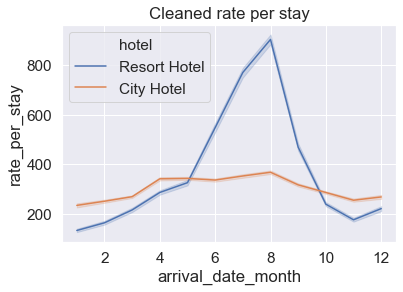

In [16]:
sns.lineplot(data = dataset, x = 'arrival_date_month', y = 'rate_per_stay', hue = 'hotel').set_title("Cleaned rate per stay")    
#Huge peak in summer months, which is to be expected.

In [17]:
def clusterMonth(RATE):
    X_month = dataset[[RATE,'arrival_date_month']]
    Xz_month = pd.DataFrame(stats.zscore(X_month),columns=[RATE,'arrival_date_month'])
    kmeans_month = KMeans(n_clusters=2).fit(Xz_month)
    cluster_month = kmeans_month.labels_
    Cluster1_month = Xz_month.loc[cluster_month  == 0]
    Cluster2_month = Xz_month.loc[cluster_month  == 1]
    print(Cluster1_month.describe())
    print(Cluster2_month.describe())
    return Cluster1_month, Cluster2_month

In [18]:
clusters = clusterMonth('rate_per_stay')

       rate_per_stay  arrival_date_month
count   34172.000000        34172.000000
mean       -0.294847           -0.918909
std         0.558021            0.513803
min        -1.268863           -1.752439
25%        -0.736726           -1.435333
50%        -0.389815           -0.801122
75%         0.007755           -0.484016
max         4.605089            0.150196
       rate_per_stay  arrival_date_month
count   40994.000000        40994.000000
mean        0.245780            0.765989
std         1.200494            0.568265
min        -1.071248           -1.752439
25%        -0.544686            0.467301
50%        -0.118202            0.784407
75%         0.648286            1.101513
max        22.438189            1.735724


In [19]:
#Validating cluster results by running k-means clustering on test data set
dataset_test = dataset
X_test = dataset_test[['rate_per_stay','arrival_date_month']]
Xz_test = pd.DataFrame(stats.zscore(X_test),columns=['rate_per_stay','arrival_date_month'])

In [20]:
kmeans_test = KMeans(n_clusters=2).fit(Xz_test)
cluster_test =kmeans_test.labels_
Cluster1_test = Xz_test.loc[cluster_test == 0]
Cluster2_test = Xz_test.loc[cluster_test == 1]
print(Cluster1_test.describe())
print(Cluster2_test.describe())

       rate_per_stay  arrival_date_month
count   34195.000000        34195.000000
mean       -0.298311           -0.917170
std         0.552491            0.515619
min        -1.268863           -1.752439
25%        -0.736726           -1.435333
50%        -0.389846           -0.801122
75%         0.006655           -0.484016
max         4.605089            0.150196
       rate_per_stay  arrival_date_month
count   40971.000000        40971.000000
mean        0.248975            0.765483
std         1.201513            0.569818
min        -1.071248           -1.752439
25%        -0.544686            0.467301
50%        -0.114702            0.784407
75%         0.655565            1.101513
max        22.438189            1.735724


In [21]:
#Clustering results of data set vs test data set looks great